# Import Library

In [191]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.exceptions import NotFittedError

In [175]:
pd.set_option("display.max_colwidth", None)

# Data Loading

In [ ]:
url = "https://storage.googleapis.com/adsp-nlp-open/data/elsevier-oa-cc-by/abstracts.json"
data = pd.read_json(url, orient="records")

In [13]:
print(f'Shape: {data.shape}')
print(f'Subjects (targets): {data.subject.unique()}')
print(f'Columns: {data.columns}')

Shape: (38686, 4)
Subjects (targets): ['phys_sci' 'healh_sci' 'engi_tech' 'life_sci' 'soc_sci']
Columns: Index(['doc_id', 'title', 'abstract', 'subject'], dtype='object')


In [12]:
data.head()

,doc_id,title,abstract,subject
0,S0960076016300644,Sterols and oxysterols in plasma from Smith-Le...,Smith-Lemli-Opitz syndrome (SLOS) is a severe ...,phys_sci
1,S1471492219301369,The Uncertainty Surrounding the Burden of Post...,Post-acute consequences currently form a signi...,healh_sci
2,S2405580815000801,Low-mass molecular dynamics simulation for con...,"It has been reported recently that classical, ...",phys_sci
3,S0142961216305853,Modulation of the molecular arrangement in art...,The transfer of material from phospholipid-coa...,engi_tech
4,S0003682X1500242X,Validation of the blocked force method for var...,Vibro-acoustic source characterization is an e...,phys_sci


# Data Preprocessing

In [41]:
le = LabelEncoder()
data["label_encoded"] = le.fit_transform(data.subject)
label_map = dict(zip(le.classes_, le.transform(le.classes_)))

In [219]:
subject_name_map = {
    "phys_sci": "Physical Sciences",
    "engi_tech": "Engineering & Technology",
    "health_sci": "Health Sciences",
    "life_sci": "Life Sciences",
    "soc_sci": "Social Sciences"
}

data["subject_full"] = data["subject"].map(subject_name_map)

In [17]:
data.all_text = data.title + " " + data.abstract

In [ ]:
def light_clean_text(text):
    if pd.isnull(text):  # handle NaNs gracefully
        return ""
    text = re.sub(r"(\s)+", " ", text)
    text = re.sub(r"([^a-zA-Z0-9])\1+", r"\1", text)
    return text.strip()

def heavy_clean_text(text_series, spacy_pipeline, n_proc=2, batch_size=1000):
    """
    Applies heavier cleaning (lemmatization, stopword & punctuation removal) for models like
    Logistic Regression or SVM.

    Args:
        text_series (pd.Series): A Series of text strings
        spacy_pipeline: A loaded spaCy language model (e.g., spacy.load("en_core_web_sm"))
        n_proc (int): Parallel processing count
        batch_size (int): Batch size for spaCy pipe

    Returns:
        pd.Series: Cleaned and normalized text
    """
    cleaned_docs = []

    for doc in spacy_pipeline.pipe(text_series, disable=["ner"], n_process=n_proc, batch_size=batch_size):
        tokens = [
            token.lemma_.lower().strip()
            for token in doc
            if not token.is_stop and not token.is_punct and not token.is_space
        ]
        cleaned_docs.append(" ".join(tokens))

    return pd.Series(cleaned_docs, index=text_series.index)

In [25]:
data['text_clean_light'] = data.all_text.apply(light_clean_text)

In [54]:
nlp = spacy.load("en_core_web_sm")
data['text_clean_heavy'] = heavy_clean_text(data.all_text, nlp)

# Exploratory Data Analysis

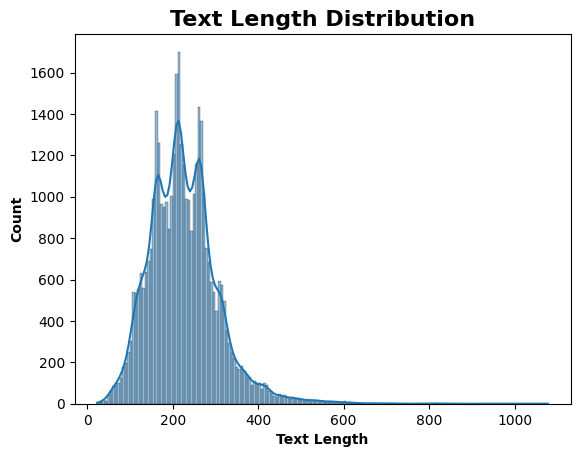

In [33]:
# checking to see the length of the documents
length_series = data.text_clean_light.str.split().str.len()

sns.histplot(length_series, kde= True)
plt.title('Text Length Distribution', fontweight= 'bold', fontsize= 16)
plt.xlabel('Text Length', fontweight= 'bold')
plt.ylabel('Count', fontweight= 'bold')
plt.show()

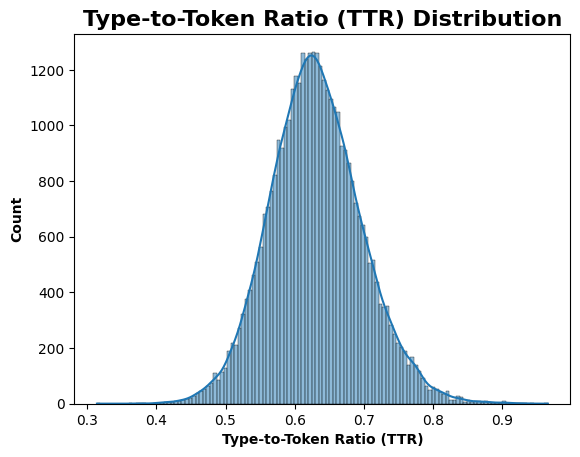

In [37]:
# type token ratio measure the diveristy in text (can help identify excessive repition)
def calc_ttr(text: str) -> float:
    words = text.split()
    unique_words = len(set(words))
    total_words = len(words)
    return unique_words / total_words if total_words > 0 else 0


# checking to see the length of the documents
data['ttr'] = data.text_clean_light.apply(calc_ttr)

sns.histplot(data.ttr, kde= True)
plt.title('Type-to-Token Ratio (TTR) Distribution', fontweight= 'bold', fontsize= 16)
plt.xlabel('Type-to-Token Ratio (TTR)', fontweight= 'bold')
plt.ylabel('Count', fontweight= 'bold')
plt.show()

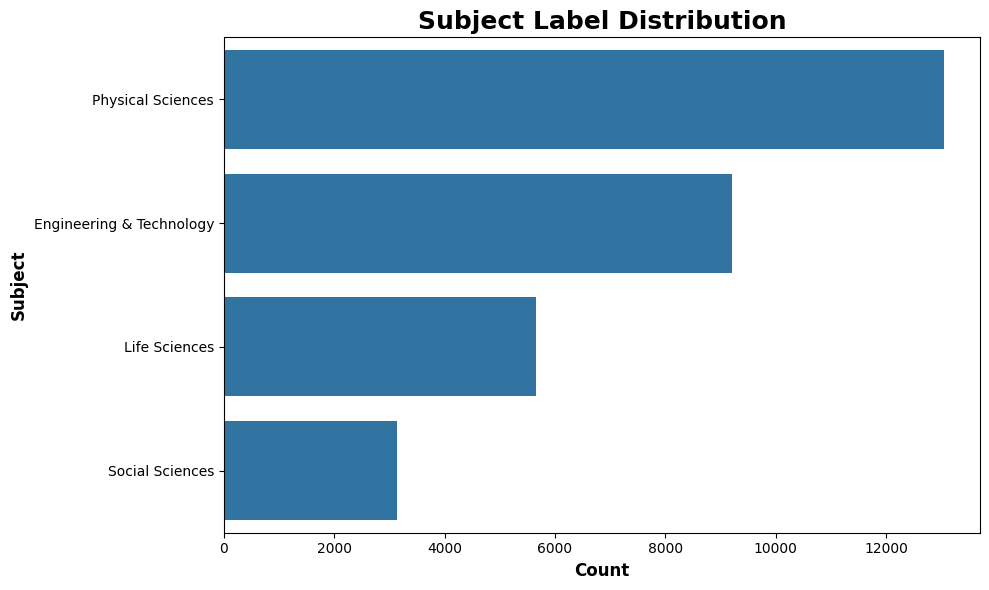

In [226]:
plt.figure(figsize=(10, 6))
sns.countplot(y="subject_full", data=data, order=data["subject_full"].value_counts().index, orient='h')
plt.title("Subject Label Distribution", fontsize=18, fontweight='bold')
plt.xlabel("Count", fontsize=12, fontweight='bold')
plt.ylabel("Subject", fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

# ML Modeling

## Data Preparation

In [192]:
def get_misclassifications_with_probas(model, X_test, y_test, text_series, label_encoder, sample_n=10):
    """
    Works with LogisticRegression, RandomForest, XGBClassifier, LinearSVC, etc.
    Handles missing .predict_proba() by falling back to .decision_function().
    """
    
    # Try to compute probabilities
    try:
        if hasattr(model, "predict_proba"):
            pred_probas = model.predict_proba(X_test)
        elif hasattr(model, "decision_function"):
            # Softmax normalization for decision_function output
            decision_scores = model.decision_function(X_test)
            if len(model.classes_) == 2:  # binary case
                decision_scores = np.column_stack([-decision_scores, decision_scores])
            exp_scores = np.exp(decision_scores)
            pred_probas = exp_scores / exp_scores.sum(axis=1, keepdims=True)
        else:
            raise ValueError("Model does not support probability or decision output.")
    except NotFittedError:
        raise ValueError("Model appears to be unfitted. Call `.fit()` before this function.")

    pred_probas = np.round(pred_probas, 3)
    pred_labels = pred_probas.argmax(axis=1)

    # Build base DataFrame
    X_test_df = (
        pd.Series(text_series)
        .to_frame(name="text")
        .assign(
            actual_label=label_encoder.inverse_transform(y_test),
            predicted_label=label_encoder.inverse_transform(pred_labels)
        )
        .reset_index(drop=True)
    )

    # Add class-wise probabilities
    proba_df = pd.DataFrame(pred_probas, columns=label_encoder.classes_)
    results_df = pd.concat([X_test_df, proba_df], axis=1)

    # Filter misclassifications
    misclassified_df = results_df[results_df["actual_label"] != results_df["predicted_label"]]

    print(f"\nFound {len(misclassified_df)} misclassified examples out of {len(results_df)} total.")
    display(misclassified_df.sample(min(sample_n, len(misclassified_df))))

    return results_df, misclassified_df


In [193]:
# Define CountVectorizer
count_vectorizer_light = CountVectorizer(
    stop_words="english",
    ngram_range= (1, 2),
    max_features= 10000
)

# Define TFIDVectorizer
tfidf_vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    max_features=10000
)

In [194]:
X_light = data.text_clean_light
X_heavy = data.text_clean_heavy
y = data.label_encoded

In [195]:
# Train/Test Split for Light Text Models
X_light_train_text, X_light_test_text, y_light_train, y_light_test = train_test_split(
    X_light, 
    y, 
    test_size=0.2, 
    random_state=42,
    stratify=y
)

X_light_train = count_vectorizer_light.fit_transform(X_light_train_text)
X_light_test = count_vectorizer_light.transform(X_light_test_text)


# Train/Test Split for Heavy Text Models
X_heavy_train_text, X_heavy_test_text, y_heavy_train, y_heavy_test = train_test_split(
    X_heavy, 
    y, 
    test_size=0.2, 
    random_state=42,
    stratify=y
)

X_heavy_train = tfidf_vectorizer.fit_transform(X_heavy_train_text)
X_heavy_test = tfidf_vectorizer.transform(X_heavy_test_text)

## Multinomial Naive Bayes

In [196]:
# Instantiate the Multinomial Naive Bayes model
nb = MultinomialNB()

# Fit the model
nb.fit(X_light_train, y_light_train)

# Predict the classes
y_pred_mnb = nb.predict(X_light_test)

              precision    recall  f1-score   support

   engi_tech       0.69      0.80      0.74      1842
   healh_sci       0.76      0.71      0.73      1527
    life_sci       0.59      0.59      0.59      1130
    phys_sci       0.72      0.53      0.61      2610
     soc_sci       0.47      0.85      0.61       629

    accuracy                           0.66      7738
   macro avg       0.65      0.70      0.66      7738
weighted avg       0.68      0.66      0.66      7738



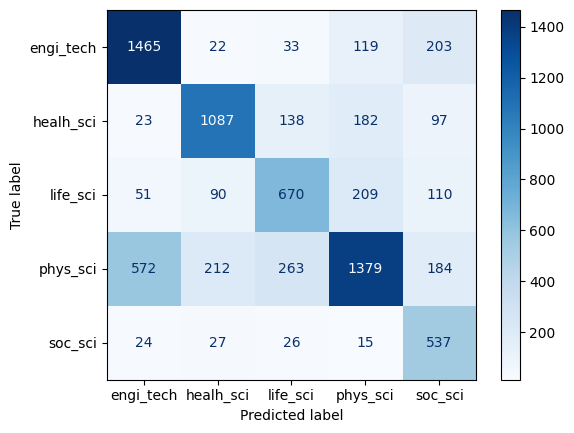

In [197]:
# Examine the classification report
print(classification_report(y_light_test, y_pred_mnb, target_names=le.classes_))

# Examine the Confusion Matrix
disp = ConfusionMatrixDisplay.from_predictions(
    y_true= y_heavy_test,
    y_pred= y_pred_mnb,
    display_labels= le.classes_,
    cmap= "Blues"
)

In [198]:
feature_names = count_vectorizer_light.get_feature_names_out()
probs = np.exp(nb.feature_log_prob_)

# Number of top words to display per class
num_top_words = 5

# Iterate over each class
for class_label in nb.classes_:

    # Get indices of top words (sorted by log probability)
    top_features = np.argsort(probs[class_label])[-num_top_words:][::-1]
    
    # Extract top words and their probabilities
    top_words = [feature_names[feat_idx] for feat_idx in top_features]  # Map indices to words
    top_probs = [probs[class_label, feat_idx] for feat_idx in top_features]  # Extract corresponding probabilities
    
    # Print words with probabilities
    print(f"\nTop words for {le.inverse_transform((class_label,))}:")
    for word, prob in zip(top_words, top_probs):
        print(f"{word}: {prob:.4f}")  # Convert log prob back to probability


Top words for ['engi_tech']:
energy: 0.0065
using: 0.0057
model: 0.0050
based: 0.0047
results: 0.0043

Top words for ['healh_sci']:
patients: 0.0066
study: 0.0058
health: 0.0042
results: 0.0041
risk: 0.0038

Top words for ['life_sci']:
study: 0.0042
data: 0.0041
using: 0.0040
species: 0.0034
results: 0.0034

Top words for ['phys_sci']:
using: 0.0044
data: 0.0040
study: 0.0039
results: 0.0035
model: 0.0034

Top words for ['soc_sci']:
study: 0.0051
data: 0.0045
health: 0.0042
paper: 0.0040
social: 0.0039


In [199]:
results_df, misclassified_df = get_misclassifications_with_probas(
    model= nb,
    X_test= X_light_test,
    y_test= y_light_test,
    text_series= X_light_test_text,
    label_encoder=le,
    sample_n= 3
)


Found 2600 misclassified examples out of 7738 total.


,text,actual_label,predicted_label,engi_tech,healh_sci,life_sci,phys_sci,soc_sci
3006,"A computational method for the coupled solution of reaction-diffusion equations on evolving domains and manifolds: Application to a model of cell migration and chemotaxis In this paper, we devise a moving mesh finite element method for the approximate solution of coupled bulk-surface reaction-diffusion equations on an evolving two dimensional domain. Fundamental to the success of the method is the robust generation of bulk and surface meshes. For this purpose, we use a novel moving mesh partial differential equation (MMPDE) approach. The developed method is applied to model problems with known analytical solutions; these experiments indicate second-order spatial and temporal accuracy. Coupled bulk-surface problems occur frequently in many areas; in particular, in the modelling of eukaryotic cell migration and chemotaxis. We apply the method to a model of the two-way interaction of a migrating cell in a chemotactic field, where the bulk region corresponds to the extracellular region and the surface to the cell membrane.",phys_sci,engi_tech,1.000,0.0,0.0,0.0,0.0
823,"Mapping human preictal and ictal haemodynamic networks using simultaneous intracranial EEG-fMRI Accurately characterising the brain networks involved in seizure activity may have important implications for our understanding of epilepsy. Intracranial EEG-fMRI can be used to capture focal epileptic events in humans with exquisite electrophysiological sensitivity and allows for identification of brain structures involved in this phenomenon over the entire brain. We investigated ictal BOLD networks using the simultaneous intracranial EEG-fMRI (icEEG-fMRI) in a 30 year-old male undergoing invasive presurgical evaluation with bilateral depth electrode implantations in amygdalae and hippocampi for refractory temporal lobe epilepsy. One spontaneous focal electrographic seizure was recorded. The aims of the data analysis were firstly to map BOLD changes related to the ictal activity identified on icEEG and secondly to compare different fMRI modelling approaches. Visual inspection of the icEEG showed an onset dominated by beta activity involving the right amygdala and hippocampus lasting 6.4 s (ictal onset phase), followed by gamma activity bilaterally lasting 14.8 s (late ictal phase). The fMRI data was analysed using SPM8 using two modelling approaches: firstly, purely based on the visually identified phases of the seizure and secondly, based on EEG spectral dynamics quantification. For the visual approach the two ictal phases were modelled as 'ON' blocks convolved with the haemodynamic response function; in addition the BOLD changes during the 30 s preceding the onset were modelled using a flexible basis set. For the quantitative fMRI modelling approach two models were evaluated: one consisting of the variations in beta and gamma bands power, thereby adding a quantitative element to the visually-derived models, and another based on principal components analysis of the entire spectrogram in attempt to reduce the bias associated with the visual appreciation of the icEEG. BOLD changes related to the visually defined ictal onset phase were revealed in the medial and lateral right temporal lobe. For the late ictal phase, the BOLD changes were remote from the SOZ and in deep brain areas (precuneus, posterior cingulate and others). The two quantitative models revealed BOLD changes involving the right hippocampus, amygdala and fusiform gyrus and in remote deep brain structures and the default mode network-related areas. In conclusion, icEEG-fMRI allowed us to reveal BOLD changes within and beyond the SOZ linked to very localised ictal fluctuations in beta and gamma activity measured in the amygdala and hippocampus. Furthermore, the BOLD changes within the SOZ structures were better captured by the quantitative models, highlighting the interest in considering seizure-related EEG fluctuations acro

## Logistic Regression

In [200]:
# Instantiate the logistic regression model
lr = LogisticRegression(class_weight='balanced', solver='saga', max_iter=1000)

# Fit the model
lr.fit(X_heavy_train, y_heavy_train)

# Predict the classes
y_pred_lr = lr.predict(X_heavy_test)

              precision    recall  f1-score   support

   engi_tech       0.77      0.78      0.78      1842
   healh_sci       0.77      0.79      0.78      1527
    life_sci       0.59      0.66      0.62      1130
    phys_sci       0.75      0.63      0.68      2610
     soc_sci       0.59      0.84      0.70       629

    accuracy                           0.72      7738
   macro avg       0.70      0.74      0.71      7738
weighted avg       0.73      0.72      0.72      7738



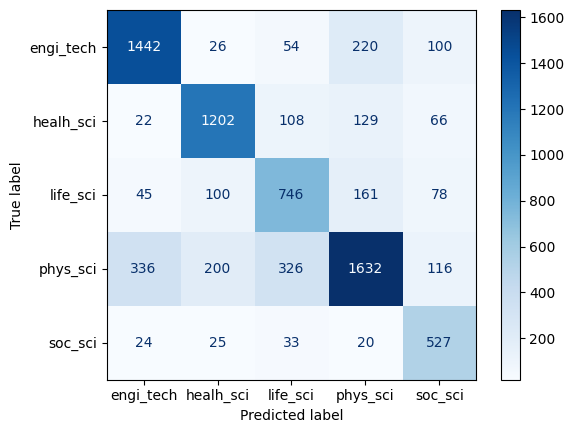

In [201]:
# Examine the classification report
print(classification_report(y_heavy_test, y_pred_lr, target_names=le.classes_))

# Examine the confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(
    y_true= y_heavy_test,
    y_pred= y_pred_lr,
    display_labels= le.classes_,
    cmap= "Blues"
)

In [202]:
feature_names = tfidf_vectorizer.get_feature_names_out()
weights = lr.coef_

# Number of top words to display per class
num_top_words = 5

# Iterate over each class
for class_label in lr.classes_:

    # Get indices of top words (sorted by log probability)
    top_features = np.argsort(weights[class_label])[-num_top_words:][::-1]
    
    # Extract top words and their probabilities
    top_words = [feature_names[feat_idx] for feat_idx in top_features]  # Map indices to words
    top_weights = [weights[class_label, feat_idx] for feat_idx in top_features]  # Extract corresponding probabilities
    
    # Print words with probabilities
    print(f"\nTop words for {le.inverse_transform((class_label,))}:")
    for word, weight in zip(top_words, top_weights):
        print(f"{word}: {weight:.4f}")  # Convert log prob back to probability


Top words for ['engi_tech']:
energy: 4.9811
paper: 3.7224
fuel: 3.2499
software: 3.1057
engineering: 2.8689

Top words for ['healh_sci']:
conclusion: 5.9545
vaccine: 5.4111
patient: 4.3442
objective: 3.9023
parasite: 3.8496

Top words for ['life_sci']:
specie: 3.4702
conservation: 3.0457
plant: 3.0296
soil: 2.9703
fmri: 2.9649

Top words for ['phys_sci']:
concentration: 2.4662
rock: 2.2427
water: 2.2422
detector: 2.2001
modification: 2.0826

Top words for ['soc_sci']:
archaeological: 4.5342
market: 3.2790
examine: 3.1947
paper: 3.1477
firm: 2.9708


In [203]:
results_df, misclassified_df = get_misclassifications_with_probas(
    model= lr,
    X_test= X_heavy_test,
    y_test= y_heavy_test,
    text_series= X_heavy_test_text,
    label_encoder= le,
    sample_n= 3
)


Found 2189 misclassified examples out of 7738 total.


,text,actual_label,predicted_label,engi_tech,healh_sci,life_sci,phys_sci,soc_sci
7583,accurate 3d reconstruction bony surface ultrasonic synthetic aperture technique robotic knee arthroplasty robotically guide knee arthroplasty system generally require individualized preoperative 3d model knee joint typically measure computed tomography ct provide require accuracy preoperative surgical intervention planning ultrasound imaging present attractive alternative ct allow reduction cost elimination dose ionize radiation whilst maintain accuracy 3d model reconstruction joint traditional phase array ultrasound imaging method susceptible poor resolution signal noise ratio snr alleviate weakness offer superior focus power synthetic aperture method investigate extensively ultrasonic non destructive testing despite fully exploit medical imaging paper ability robotic deploy ultrasound imaging system base synthetic aperture method accurately reconstruct bony surface investigate employ total focussing method tfm synthetic aperture focusse technique saft sample image representative bone knee joint human shaped composite distal femur bovine distal femur datum capture 5 mhz 128 element 1d phase array manipulate sample robotic positioning system dimensional surface reconstruction produce compare reference model measure precision laser scanner mean error 0.82 mm 0.88 mm obtain composite bovine sample respectively demonstrate feasibility approach deliver sub millimetre accuracy require application,healh_sci,engi_tech,0.457,0.218,0.074,0.228,0.023
1597,effect enzyme replacement therapy clinical outcome female patient fabry disease systematic literature review european panel expert background heterozygous female fabry disease wide range clinical phenotype depend nature mutation x chromosome inactivation pattern important examine outcome enzyme replacement therapy ert female patient population specifically paper present finding systematic literature review treatment outcome ert adult female patient method comprehensive systematic literature review conduct january 2017 retrieve publish paper original datum ert treatment fabry disease review include original article present ert outcome datum patient fabry disease irrespective study type result clinical evidence efficacy ert female patient available 67 publication include clinical trial publication indicate significant reduction plasma urine globotriaosylceramide gl-3 accumulation female patient elevated pre treatment level improvement cardiac parameter quality life qol date datum insufficient conclude effect ert nervous system gastrointestinal manifestation pain female patient fabry disease conclusion review available literature datum demonstrate ert adult female patient fabry disease beneficial effect gl-3 level cardiac outcome current evidence suggest ert improve qol patient population study need examine result,phys_sci,healh_sci,0.018,0.573,0.113,0.279,0.018
5903,generic rigidity triangulate sphere block hole simple graph g=(v e 3 rigid generic bar joint framework r3 infinitesimally rigid block hole graph derive triangulate sphere removal edge addition minimally rigid subgraph know block result hole combinatorial characterisation minimal 3 rigidity obtain graph case single block finitely hole single hole finitely block result confirm conjecture whiteley 1988 special case strong conjecture finbow singh whiteley 2013,engi_tech,phys_sci,0.343,0.044,0.037,0.553,0.024


## Linear Support Vector Classification

In [204]:
# Instantiate the Linear SVC model
svc = LinearSVC(class_weight= 'balanced')

# Fit the model
svc.fit(X_heavy_train, y_heavy_train)

# Predict the classes
y_pred_svc = svc.predict(X_heavy_test)

              precision    recall  f1-score   support

   engi_tech       0.76      0.77      0.76      1842
   healh_sci       0.77      0.78      0.77      1527
    life_sci       0.58      0.62      0.60      1130
    phys_sci       0.72      0.67      0.69      2610
     soc_sci       0.63      0.73      0.68       629

    accuracy                           0.71      7738
   macro avg       0.69      0.71      0.70      7738
weighted avg       0.71      0.71      0.71      7738



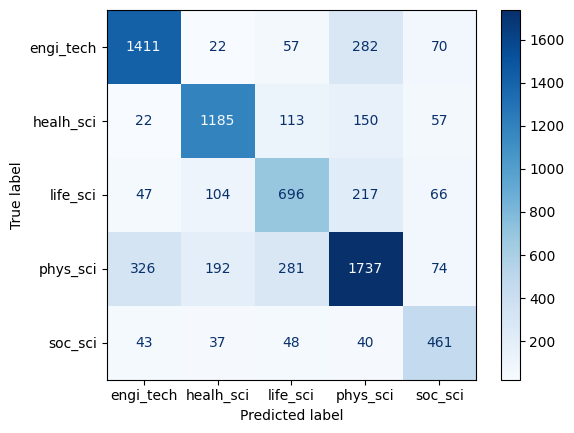

In [205]:
# Examine the classification Report
print(classification_report(y_heavy_test, y_pred_svc, target_names=le.classes_))

# Examine the confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(
    y_true= y_heavy_test,
    y_pred= y_pred_svc,
    display_labels= le.classes_,
    cmap= "Blues"
)

In [206]:
num_top_words = 10

# Get feature names from the vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Get class labels
class_labels = svc.classes_

# For each class, find top N features
for class_index, class_label in enumerate(class_labels):
    # Get coefficients for this class
    coef = svc.coef_[class_index]

    # Get indices of top features (most positive weights)
    top_indices = np.argsort(coef)[-num_top_words:][::-1]

    print(f"\nTop words for class '{le.inverse_transform([class_label])[0]}':")
    for i in top_indices:
        print(f"{feature_names[i]}: {coef[i]:.4f}")


Top words for class 'engi_tech':
crash: 2.4604
software: 2.0493
combustion: 2.0442
paper: 2.0063
osteoarthritis: 1.9635
accident: 1.9552
tungsten: 1.9385
paste: 1.9384
energy: 1.8863
biocompatibility: 1.8816

Top words for class 'healh_sci':
conclusion: 5.1836
objective: 3.3859
introduction: 3.2893
photoacoustic: 3.0706
surgical: 2.7829
funding: 2.7731
immunization: 2.6312
vaccine: 2.5519
anthelmintic: 2.3887
tick: 2.3377

Top words for class 'life_sci':
exist method: 3.1258
connectome: 2.9242
transect: 2.5344
ecosystem service: 2.5305
bread: 2.5152
diffusion mri: 2.4898
fmri: 2.4412
mic: 2.3666
new method: 2.2972
neuroscience: 2.2775

Top words for class 'phys_sci':
pku: 2.4765
radionuclide: 2.1857
climate service: 2.1851
water supply: 1.9485
sludge: 1.9220
oncolytic: 1.8992
bioinformatics: 1.8600
microplastic: 1.8235
rock: 1.8119
lhc: 1.8105

Top words for class 'soc_sci':
archaeological: 4.5552
contemporary: 2.5943
physical health: 2.5577
holocene: 2.3192
linguistic: 2.2859
bp: 2.1

In [207]:
results_df, misclassified_df = get_misclassifications_with_probas(
    model= svc,
    X_test= X_heavy_test,                 
    y_test= y_heavy_test,
    text_series= X_heavy_test_text,       
    label_encoder= le,
    sample_n= 3
)


Found 2247 misclassified examples out of 7738 total.


,text,actual_label,predicted_label,engi_tech,healh_sci,life_sci,phys_sci,soc_sci
3281,effect low level prenatal lead exposure child iq 4 8 year uk birth cohort study background association childhood exposure lead pb deficit cognitive function establish association prenatal exposure understand potential adverse effect equally important objective evaluate association low prenatal exposure lead iq child determine sex difference association evaluate moderation effect prenatal pb exposure child iq method blood sample pregnant woman enrol alspac n = 4285 offspring age 30 month n = 235 analyse pb associations prenatal blood lead concentration b pb child iq age 4 8 year wppsi wisc iii respectively examine adjust regression model result association prenatal lead exposure child iq 4 8 year old adjusted regression model moderation association child b pb iq positive association iq age 8 year girl predict increase iq point 1 μg dl verbal 0.71 performance 0.57 total 0.73 boy coefficient tend negative −0.15 −0.42 −0.29 point respectively conclusion prenatal lead exposure associate adverse effect child iq age 4 8 year study evidence suggest boy susceptible girl prenatal exposure lead investigation cohort require,life_sci,healh_sci,0.093,0.485,0.119,0.141,0.162
7360,cross flow structured packing process intensification post combustion carbon dioxide capture introduce novel insight cross flow arrangement structured packing specifically post combustion carbon dioxide capture gas liquid dynamic investigate numerically liquid flow action gravity gas drive horizontal pressure gradient cross liquid phase elementary packing cell consist connect channel depict co current gas liquid flow depict counter current phase flow flow reversal liquid phase occur counter flow channel high gas flow rate overall flooding point significantly delay comparison counter current flow arrangement traditionally structured packing vary gas flow rate tilt angle elementary cell detailed numerical analysis flow repartition channel pressure drop gas liquid velocity onset flooding present pressure drop find small tilt cell respect initial scenario 45 ° flow reversal instead delay lower tilting angle cell tilt anti clockwise reveal presence long wave edge cell low tilting angle finally datum wet pressure drop cross flow cell compare different commercially available type packing arrange conventional vertical counter flow configuration version sulzer mellapak ™,engi_tech,phys_sci,0.315,0.034,0.092,0.492,0.067
6441,magnetic structure palaeomagnetic recording fidelity sub micron greigite fe3s4 present result finite element micromagnetic model 30 nm 300 nm greigite fe3s4 grain variety equant morphology grain size range cover magnetic single domain sd pseudo single domain psd transition possibly psd multi domain md transition sd psd threshold d0 determined 50nm≤d0≤56 nm depend grain shape nudge elastic band method determine room temperature energy barrier stable state block volume find absence interparticle magnetostatic interaction magnetisation equant sd greigite stable geological scale psd grain ≥70 nm expect carry stable magnetisation billion year timescale i.e. non interacting sd particle essentially superparamagnetic identify mechanism psd multi domain md transition continuous nature psd nucleation 300 nm structure typical md behaviour like closure domain begin form,phys_sci,engi_tech,0.381,0.140,0.102,0.348,0.029


## Random Forest

In [208]:
# Instantiate the random forest model
rf = RandomForestClassifier(class_weight= 'balanced')

# Fit the model
rf.fit(X_heavy_train, y_heavy_train)

# Predict the classes
y_pred_rf = rf.predict(X_heavy_test)

              precision    recall  f1-score   support

   engi_tech       0.71      0.79      0.74      1842
   healh_sci       0.74      0.79      0.76      1527
    life_sci       0.69      0.40      0.51      1130
    phys_sci       0.63      0.68      0.66      2610
     soc_sci       0.68      0.63      0.65       629

    accuracy                           0.68      7738
   macro avg       0.69      0.66      0.66      7738
weighted avg       0.68      0.68      0.68      7738



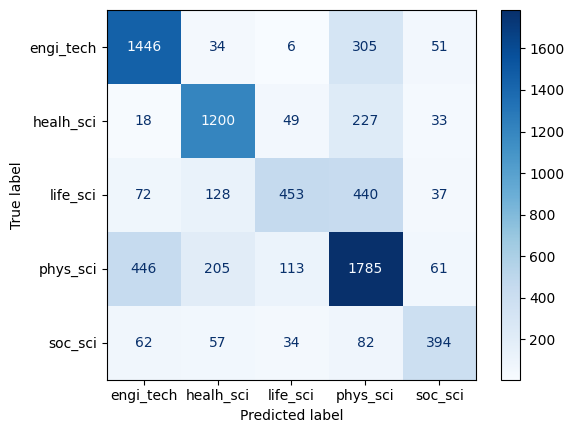

In [209]:
# Examine the classification report
print(classification_report(y_heavy_test, y_pred_rf, target_names=le.classes_))

# Examine the confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(
    y_true= y_heavy_test,
    y_pred= y_pred_rf,
    display_labels= le.classes_,
    cmap= "Blues"
)

In [210]:
num_top_words = 10
#  Get feature names from your vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Get feature importances from XGBoost model
importances = rf.feature_importances_

# Get indices of top features
top_indices = np.argsort(importances)[-num_top_words:][::-1]

# Display top features and their importances
print("\nTop global features by importance (XGBoost):")
for i in top_indices:
    print(f"{feature_names[i]}: {importances[i]:.4f}")


Top global features by importance (XGBoost):
patient: 0.0080
conclusion: 0.0078
paper: 0.0076
energy: 0.0056
background: 0.0054
disease: 0.0052
infection: 0.0048
vaccine: 0.0047
method: 0.0046
specie: 0.0042


In [211]:
results_df, misclassified_df = get_misclassifications_with_probas(
    model= rf,
    X_test= X_heavy_test,                 
    y_test= y_heavy_test,
    text_series= X_heavy_test_text,       
    label_encoder= le,
    sample_n= 3
)


Found 2460 misclassified examples out of 7738 total.


,text,actual_label,predicted_label,engi_tech,healh_sci,life_sci,phys_sci,soc_sci
1384,extension mtpi teqr design include non monotone efficacy addition toxicity optimal dose determination early phase immunotherapy oncology trial emergence immunotherapy novel therapy traditional assumption efficacy study drug increase monotonically dose level true dose find method evaluate toxicity datum adequate paper compare modified toxicity probability interval mtpi toxicity equivalence range teqr dose find oncology design safety identical stopping rule extend design include efficacy addition safety determine optimal dose safety efficacy design apply isotonic regression observed toxicity efficacy rate early phase trial complete consider multiple type underlie dose response curve i.e. monotonically increase plateau umbrella shaped conduct simulation study investigate operate characteristic propose design compare exist design find extended mtpi design select optimal dose safety efficacy accurately design scenario consider,life_sci,engi_tech,0.41,0.14,0.10,0.29,0.06
3210,relationship network governance unilateral governance dynamic consumer demand important question retailer extent control supplier maintain uncertain consumer demand paper propose level network governance high low affect retailer level unilateral control uncertain consumer demand empirical result indicate low level network governance retailer tend increase level unilateral control supplier consumer demand uncertainty increase hand retailer feel high level network governance rely unilateral governance less extent regardless consumer demand uncertainty,soc_sci,engi_tech,0.41,0.01,0.07,0.21,0.30
4252,cost effective erosion monitoring coastal cliff structure motion multi view stereo sfm mvs method hold potential monitoring quantify cliff erosion level accuracy precision rival terrestrial laser scan tls fraction cost benchmark repeat sfm mvs tls quantify rock fall frequency volume cliff face erosion rate ∼1 km section coastal cliff cliff infrastructure threaten erosion address major unknown technique number configuration control point survey demonstrate sparse configuration cliff base space equivalent cliff height provide suitable accuracy acceptable logistic time expense second sfm mvs model match equivalent tls datum 0.04 m correlation intersect tls- sfm derive rock fall volume improve markedly detection threshold 0.07 m3 rock fall size threshold account ∼77.7 detect rock fall 1.9 calculate annual erode volume annual erosion rate 1 km cliff face calculate repeat tls sfm differencing 0.6 × 10−2 m a−1 0.7 × 10−2 m a−1 respectively kilometre scale pattern cliff erosion dominate localise zone high magnitude episodic failure order magnitude great background rate ability non specialist engineer geologist geomorphologist manager rapidly capture high quality accurate erosion datum cost effective manner repeat sfm mvs significant potential inform coastal manager decision maker empower coastal authority community policy framework develop incorporate interpret datum,engi_tech,phys_sci,0.24,0.17,0.14,0.34,0.11


## XG Boost

In [212]:
# Instantiate the XG Boost model
xgb = XGBClassifier()

# Fit the model
xgb.fit(X_heavy_train, y_heavy_train)

# Predict the classes
y_pred_xgb = xgb.predict(X_heavy_test)

              precision    recall  f1-score   support

   engi_tech       0.75      0.74      0.74      1842
   healh_sci       0.77      0.77      0.77      1527
    life_sci       0.67      0.52      0.58      1130
    phys_sci       0.64      0.72      0.68      2610
     soc_sci       0.69      0.62      0.65       629

    accuracy                           0.70      7738
   macro avg       0.70      0.67      0.69      7738
weighted avg       0.70      0.70      0.70      7738



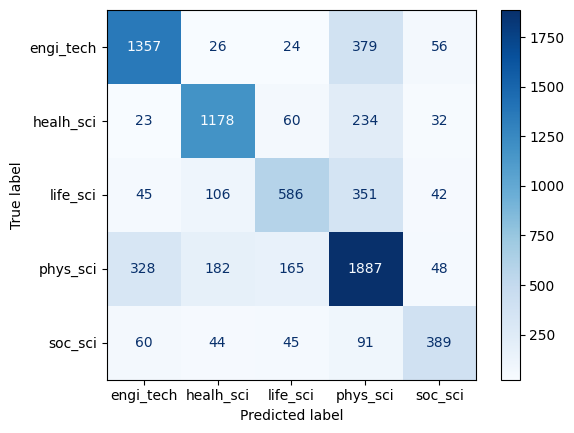

In [213]:
# Examine the classification report
print(classification_report(y_heavy_test, y_pred_xgb, target_names=le.classes_))

# Examine the confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(
    y_true= y_heavy_test,
    y_pred= y_pred_xgb,
    display_labels= le.classes_,
    cmap= "Blues"
)

In [214]:
num_top_words = 10
#  Get feature names from your vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Get feature importances from XGBoost model
importances = xgb.feature_importances_

# Get indices of top features
top_indices = np.argsort(importances)[-num_top_words:][::-1]

# Display top features and their importances
print("\nTop global features by importance (XGBoost):")
for i in top_indices:
    print(f"{feature_names[i]}: {importances[i]:.4f}")


Top global features by importance (XGBoost):
conclusion: 0.0080
alloy: 0.0058
finite element: 0.0058
composite: 0.0047
infection: 0.0046
steel: 0.0041
crop: 0.0038
background: 0.0036
market: 0.0034
fuel: 0.0034


In [215]:
results_df, misclassified_df = get_misclassifications_with_probas(
    model= xgb,
    X_test= X_heavy_test,                 
    y_test= y_heavy_test,
    text_series= X_heavy_test_text,       
    label_encoder= le,
    sample_n= 3
)


Found 2342 misclassified examples out of 7738 total.


,text,actual_label,predicted_label,engi_tech,healh_sci,life_sci,phys_sci,soc_sci
322,frontal vagal network theory major depressive disorder implication optimize neuromodulation technique major depressive disorder mdd psychiatric disorder characterize high comorbidity cardiovascular disease furthermore combination high heart rate hr low heart rate variability hrv frequently report depressed patient present review propose frontal vagal brain heart network overlaps functional node depression network summarize neuromodulation study target key node depression network subsequent impact heart rate hr heart rate variability hrv dorsolateral prefrontal cortex dlpfc subgenual anterior cingulate cortex sgacc vagus nerve vn base interplay frontal vagal network emphasize importance include hr hrv measurement human depression study particular conduct neuromodulation order obtain well understanding pathway affect explore possibility frontal vagal interplay method target engagement neuromodulation treatment frontal vagal network theory open possibility individualize neuromodulation treatment rtm recent development call neuro cardiac guided tms ncg tms develop base theory individual participant meta analysis present study provide consistent replicable support ncg tms target engagement method consistent hr deceleration frontal tms hr acceleration motor strip tms,phys_sci,life_sci,0.013,0.317,0.549,0.114,0.007
3562,incorporate hydrogen mesoscale model hydrogen embrittlement major longstanding challenge material science mesoscale mechanical model currently develop provide new insight hydrogen dislocation interaction subsequent detrimental effect ductility ultimate tensile strength review recent approach incorporate hydrogen crystal plasticity discrete dislocation plasticity cohesive zone model review modelling scale bridge gap atomistic model continuum engineering model essential fully understand hydrogen embrittlement,phys_sci,engi_tech,0.894,0.009,0.019,0.067,0.011
1897,antiplane elastic wave propagation pre stressed periodic structure tuning band gap switching invariance effect nonlinear elastic pre stress antiplane elastic wave propagation dimensional periodic structure investigate medium consist cylindrical annulus embed periodic square lattice uniform host material identical inhomogeneous deformation impose annulus theory small large find incremental wave equation govern subsequent small amplitude antiplane wave plane wave expansion method employ order determine permissable eigenfrequencie find pre stress significantly affect band gap structure mooney rivlin fung type material allow stop band switch show specific class material phononic property remain invariant nonlinear deformation permit interesting behaviour lead possibility phononic cloak,phys_sci,engi_tech,0.733,0.027,0.029,0.197,0.015


# Analysis

## What kind of models did you try and why?

As seen above, we selected a wide range of models based on both their alignment with our preprocessing steps as well as their text classification model complexity. Specifically, we did two types of preprocessing in parallel: a light cleaning that is best suited for BOW models (Multinomial Naive Bayes), and a heavy cleaning that is better suited for more complex models (Logistic Regression, Linear Support Vector Classifier, Random Forest, and XG Boost).

In the light cleaning pipeline, we preserved the raw term structure and only removed extra spaces and duplicate non alphanumeric characters. For the heavy cleaning pipeline we additionally applied lemmatization and stopword removal. For the BOW model (Multinomial Naive Bayes), we used a count vectorizer (and removed stop words after intially seeing that they were the top words in each class). However, for the other models, we used a TFID vectorizer to capture additional patterns missed by simpler baselines. Ultimately, this structured approach allowed us to isolate the impact of both model choice and preprocessing strategy on classification performance.

**Cicily to discuss decision to combine title and abstracts + trying ensemble methods**

## How did you evaluate the model and which metric do you think is most important?

Ultimately, we evaluated all models using precision, recall, confusion matrices, top words, and misclassifications. Together, these allowed us to assess both the overall performance and per-class behavior. Given the moderate class imbalance in our dataset, we tended to prioritized the (macro) F1 as the most important metric, since it ensures each class contributes equally to the evaluation, regardless of size. We also made sure to address the class imbalance by setting the model class weight to `'balanced'`, where possible. However, accuracy and F1 scores alone can be misleading, so we made sure to closely examine the various confusion matrices, top words by class and misclassifications to wholistically gauge the performance of each model.

## How did you investigate misclassifications?

To investigate misclassifications, we examined the original text, true label, and predicted label for each of misclassifications by model (note: we also considered showing the probabilities, but not all of our models had a probabilistic output). Looking at the actual text of misclassifications allowed us to determine if the model was understandably wrong, or just failing. Paired with our examination of the confusion matrices, we were able to detect consistent class-level confusion, and reviewed individual misclassified texts to understand whether errors stemmed from ambiguous language, overlapping subject matter, or preprocessing artifacts. This combination of qualitative and quantitative analysis helped us get a strong and wholistic guage of model performance.

## Were misclassifications understandable (genuinely difficult examples) or were they blatant errors? Provide a few examples?

From examining the misclassifications (as mentioned above), we found that most misclassifications were understandable and reflected genuinely difficult cases rather than model failure. Specifically, many abstracts included interdisciplinary language that blurs the line between classes like phys_sci, engi_tech, and life_sci. 

For example, a study on ototoxicity and aspirin use in chemotherapy was misclassified as health_sci instead of phys_sci, which seems  reasonable given the clinical language and medical framing. As another example, a paper on carbon dioxide reduction via E. coli (a biochemical process) was predicted as phys_sci despite being labeled life_sci, likely due to overlapping terminology with chemistry and energy research. Ultimately, these examples suggest the model is generally making informed guesses in ambiguous contexts, rather than committing blatant errors.